In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
%matplotlib inline 

In [2]:
ames = pd.read_csv('./data/Ames_Housing_Price_Data.csv')
ames = ames.iloc[:,1:]

## Feature type check

In [3]:
ames.columns = ames.columns.str.lower()
ames.mssubclass = ames.mssubclass.astype('object')
ames.mosold = ames.mosold.astype('object')

By readling the data dictionaory, a few features come in ordinary scale, such as 'OverallQual' and 'OverallCond'. To decide whether or not to convert these data type, we check the scatter plot of saleprice against these features, to see if there is a linear pattern.

In [4]:
oridinal_col = ['overallqual','overallcond','exterqual','extercond','bsmtqual','bsmtcond','bsmtfintype1',\
                'bsmtfintype2','kitchenqual','fireplacequ','poolqc','garagecond','garagequal']

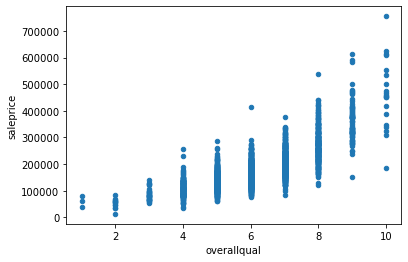

In [6]:
ames[['overallqual','saleprice']].plot(x='overallqual',y='saleprice',kind='scatter')

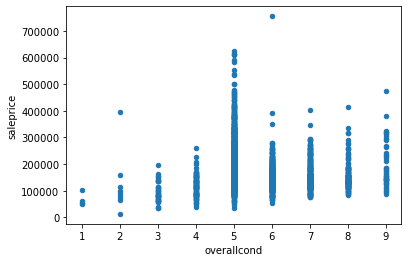

In [7]:
ames[['overallcond','saleprice']].plot(x='overallcond',y='saleprice',kind='scatter')

'overallqual' and 'overallcond' show nearly linear pattern, therefore these 2 columns will be treated as numeric values in the data set. All others will be treated as categorial features.

## Missing Data Cleanning

Missingness: it seems that all the missing come from a non-existing feature, therefore I fill in all the numeric features with 0 and categorical features with ‘No [feature]’ or similar pattern. 

### Remarks:

*mansvnrtype / masvnrarea: missing because the house is solid brick? In that case, the price might be different.

*garage: row 433, 531 have garage type but with many missing values in garage specs

*‘Electrical’ : 1 missing data

*When 'Garagetype' is ‘no garage’, the value of 'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond' will have multicollinearity since they will all be coded 0 or ‘No Garage’. For ML purposes, the overall model will include ‘garagetype’ or 'garagearea' only, if significant, the data set will be split in with/without garage for further analysis.

*The same with the basement features group.

In [8]:
ames.loc[ames.lotfrontage.isnull(),'lotfrontage'] = 0
ames.loc[ames.alley.isnull(),'alley'] = 'No Alley'
ames.loc[ames.masvnrtype.isnull(),'masvnrtype'] = 'Missing'
ames.loc[ames.masvnrarea.isnull(),'masvnrarea'] = 0
ames.loc[ames.bsmtqual.isnull(),'bsmtqual'] = 'No Bsmt'
ames.loc[ames.bsmtcond.isnull(),'bsmtcond'] = 'No Bsmt'
ames.loc[ames.bsmtexposure.isnull(),'bsmtexposure'] = 'No Bsmt'
ames.loc[ames.bsmtfintype1.isnull(),'bsmtfintype1'] = 'No Bsmt'
ames.loc[ames.bsmtfinsf1.isnull(),'bsmtfinsf1'] = 0
ames.loc[ames.bsmtfintype2.isnull(),'bsmtfintype2'] = 'No Bsmt'
ames.loc[ames.bsmtfinsf2.isnull(),'bsmtfinsf2'] = 0
ames.loc[ames.bsmtunfsf.isnull(),'bsmtunfsf'] = 0
ames.loc[ames.totalbsmtsf.isnull(),'totalbsmtsf'] = 0
ames.loc[ames.bsmtfullbath.isnull(),'bsmtfullbath'] = 0
ames.loc[ames.bsmthalfbath.isnull(),'bsmthalfbath'] = 0
ames.loc[ames.fireplaces == 0,'fireplacequ'] = 'No Fireplace'
ames.loc[ames.garagetype.isnull(),'garagetype'] = 'No Garage'
ames.loc[ames.garagetype == 'No Garage','garageyrblt'] = 0
ames.loc[ames.garagetype == 'No Garage','garagefinish'] = 'No Garage'
ames.loc[ames.garagetype == 'No Garage','garagecars'] = 0
ames.loc[ames.garagetype == 'No Garage','garagearea'] = 0
ames.loc[ames.garagetype == 'No Garage','garagequal'] = 'No Garage'
ames.loc[ames.garagetype == 'No Garage','garagecond'] = 'No Garage'
ames.loc[ames.poolarea == 0,'poolqc'] = 'No Pool'
ames.loc[ames.fence.isnull(),'fence'] = 'No Fence'
ames.loc[ames.miscfeature.isnull(),'miscfeature'] = 'None'

In [9]:
ames.loc[ames.garageyrblt.isnull(),]

,pid,grlivarea,saleprice,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
433,910201180,1828,150909,70,RM,50.0,9060,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,0.0,0.0,2,0,3,1,Gd,6,Typ,0,No Fireplace,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,No Pool,MnPrv,None,0,3,2007,WD,Alloca
531,903426160,1984,160000,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,0.0,0.0,2,0,5,1,TA,8,Typ,0,No Fireplace,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,No Pool,MnPrv,Shed,1000,9,2008,WD,Normal


In [10]:
ames.loc[ames.electrical.isnull(),]

,pid,grlivarea,saleprice,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
2442,916386080,1394,167500,80,RL,73.0,9735,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,NaN,754,640,0,0.0,0.0,2,1,3,1,Gd,7,Typ,0,No Fireplace,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,No Pool,No Fence,None,0,5,2008,WD,Normal


After the major data cleaning, 3 rows are still left with missing values. After checking the 3 records, the missing information cannot be imputed easily with existing information, so we decide to remove these 3 rows. 2577 rows of data will be included in the analysis.

In [11]:
ames2 = ames.dropna(axis=0).copy()
ames2.shape

(2577, 81)

## Adding Features

- 'price_sqft' = 'saleprice' / 'grlivarea'
 
- 'house_age'  = 'yrsold' - 'yearbuilt'
 
- 'reno_age' = 'yrsold' - 'yearremodadd'
 
- bathroom # above ground: 'tbath_abvgr' = 'fullbath' + 'halfbath'*0.5

- bathroom # in basement: 'tbath_bsmt' = 'bsmtfullbath' + 'bsmthalfbath'*0.5
 
- bedroom/bathroom ratio (above ground): 'bbratio_abvgr' = 'bedroomabvgr' / 'tbath_abvgr'
  
There are two houses only have bathroom in basement, so the 'bbratio_abvgr' will be uncalculatble. 

To make sense of the date, impute the missing data with 10.

### Be aware of multicollinearity between the introduced variables

In [12]:
ames2['price_sqft'] = ames2['saleprice'] / ames2['grlivarea']
ames2['house_age'] = ames2['yrsold'] - ames2['yearbuilt']
ames2['reno_age'] = ames2['yrsold'] - ames2['yearremodadd']
ames2.loc[ames2['reno_age']<0,'reno_age'] = 0
ames2['tbath_abvgr'] = ames2['fullbath'] + ames2['halfbath']*0.5
ames2['tbath_bsmt'] = ames2['bsmtfullbath'] + ames2['bsmthalfbath']*0.5
ames2['tbath'] = ames2['tbath_abvgr'] + ames2['tbath_bsmt']
ames2['bbratio_abvgr'] = ames['bedroomabvgr']/ames2['tbath_abvgr']
ames2.loc[ames2['bbratio_abvgr'].isnull(),'bbratio_abvgr'] = 10
ames2.loc[ames2['bbratio_abvgr']>10,'bbratio_abvgr'] = 10

## Check Outliers

outliers: price higher or lower than 3 std

In [13]:
ames2[['saleprice','price_sqft']].describe()

,saleprice,price_sqft
count,2577.000000,2577.000000
mean,178081.264649,120.934759
std,75071.726566,30.637014
min,12789.000000,15.371394
25%,129900.000000,100.401606
50%,159900.000000,119.658120
75%,210000.000000,138.888889
max,755000.000000,276.250881


In [14]:
price_outliers = ames2[((ames2['saleprice'] - ames2['saleprice'].mean())/ames2['saleprice'].std() > 3) | \
     ((ames2['saleprice'] - ames2['saleprice'].mean())/ames2['saleprice'].std() < -3)]
outliersp = price_outliers.pid.tolist()
len(price_outliers)

42

In [15]:
price_outliers.groupby('neighborhood').count()[['pid']].reset_index()

,neighborhood,pid
0,CollgCr,1
1,Edwards,1
2,NoRidge,8
3,NridgHt,20
4,OldTown,1
5,Somerst,3
6,StoneBr,6
7,Timber,2


In [16]:
price_outliers['saleprice'].mean()

479349.2380952381

In [17]:
pps_outliers = ames2[((ames2['price_sqft'] - ames2['price_sqft'].mean())/ames2['price_sqft'].std() > 3) | \
     ((ames2['price_sqft'] - ames2['price_sqft'].mean())/ames2['price_sqft'].std() < -3)]
outliers2 = pps_outliers.pid.tolist()
len(pps_outliers)

19

In [18]:
pps_outliers.groupby('neighborhood').count()[['pid']].reset_index()

,neighborhood,pid
0,Crawfor,1
1,Gilbert,1
2,GrnHill,1
3,NridgHt,8
4,OldTown,1
5,Somerst,2
6,StoneBr,4
7,Timber,1


The outliers in terms of saleprice are all high price houses, while the outliers per price_sqft have high value and low value houses. 13 houses are marked outliers under both criterias. We may consider removing these houses for general model.

In [19]:
outlier_pid = list(set(outliersp).intersection(set(outliers2)))
outlier_pid 

[528431040,
 528114050,
 528118050,
 528106020,
 528110020,
 527256040,
 527216080,
 921128050,
 528150070,
 527256120,
 528114010,
 528164060,
 528106110]

## Preparing data set

### Categorical Variables

Creating a list of all categorial variable for future uses.

Check the Boxplots for all categorical variable against price per sqft

In [26]:
dummy_dict = {}
factor_col = []
for col in ames2.columns:
    if ames2[col].dtype == 'O':
        dummy_dict[col] = pd.get_dummies(ames2[col],prefix=col, prefix_sep='_')
        factor_col.append(col)

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\Chun\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


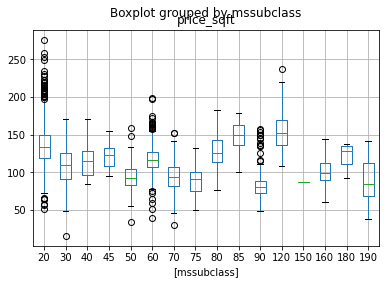

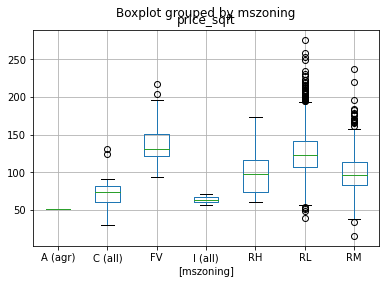

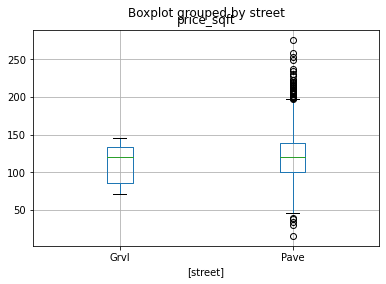

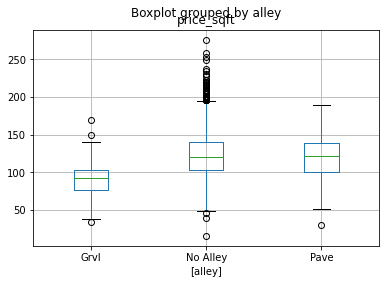

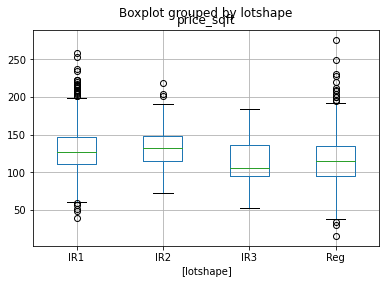

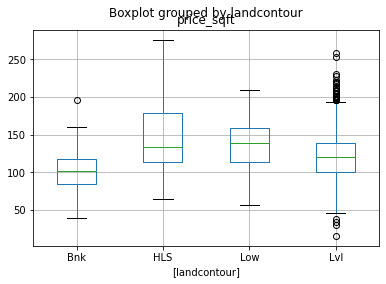

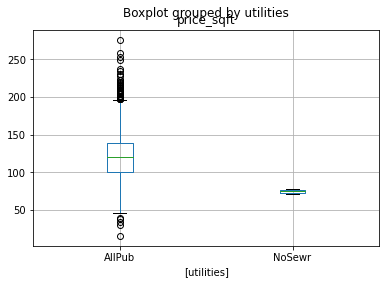

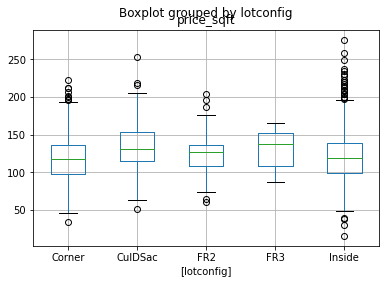

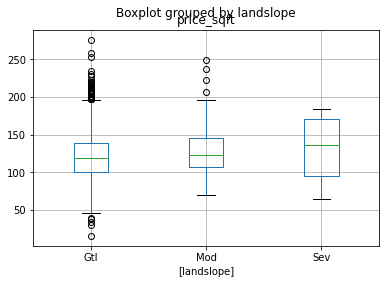

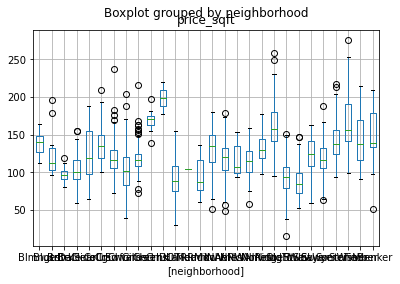

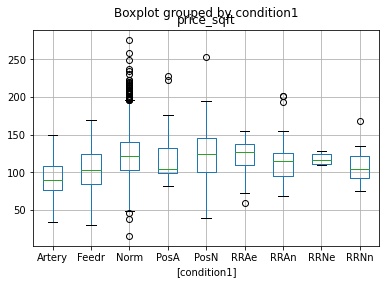

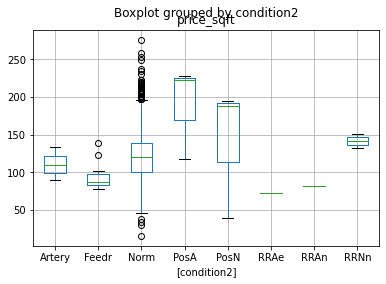

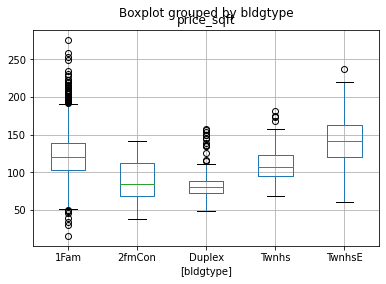

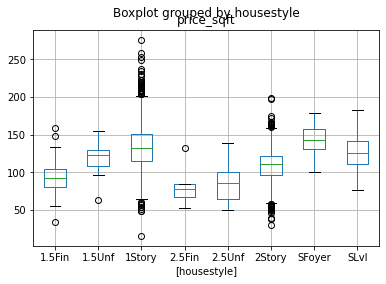

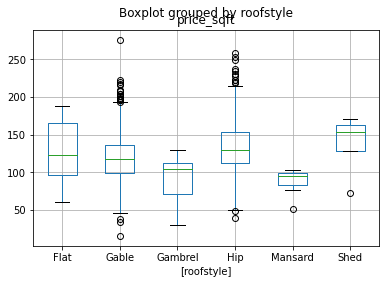

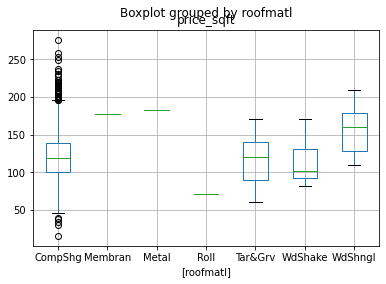

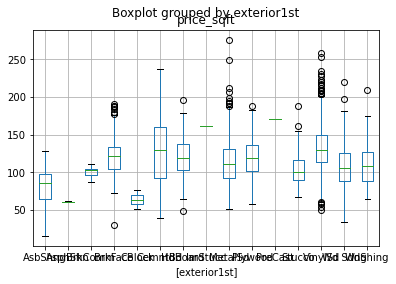

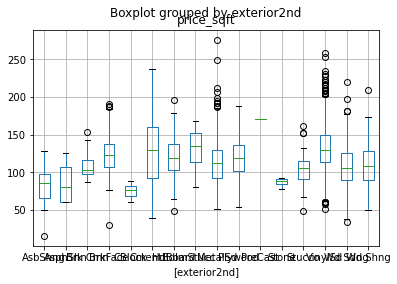

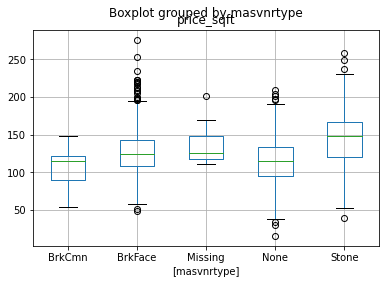

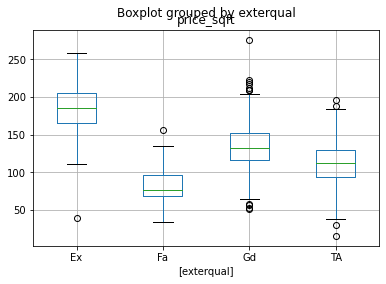

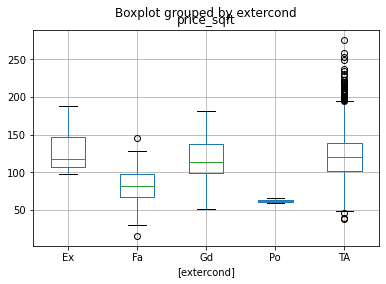

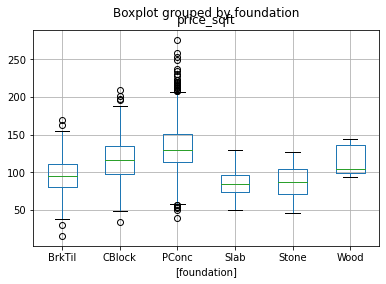

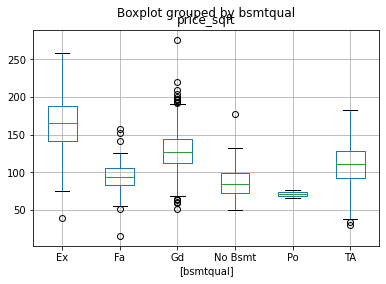

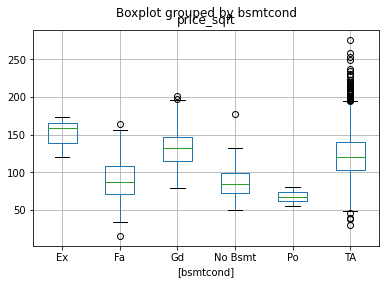

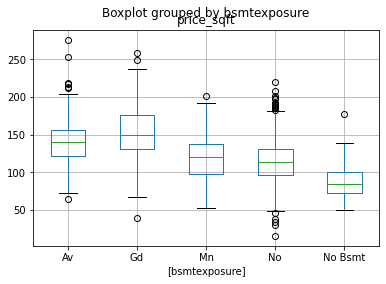

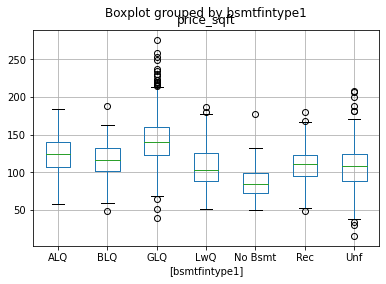

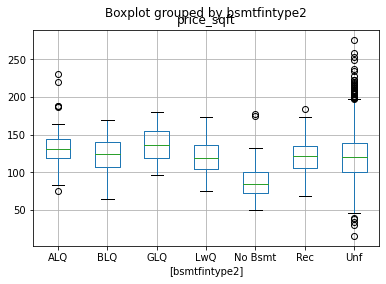

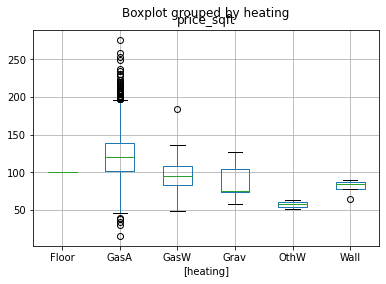

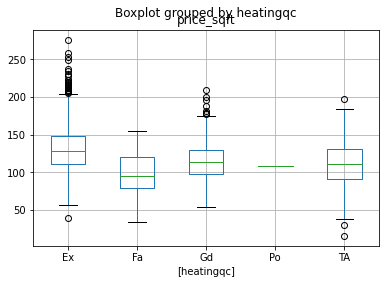

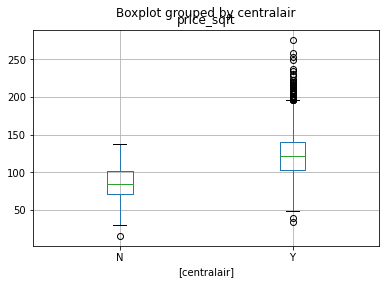

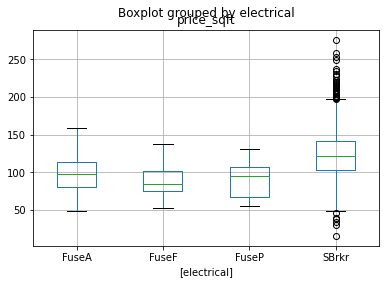

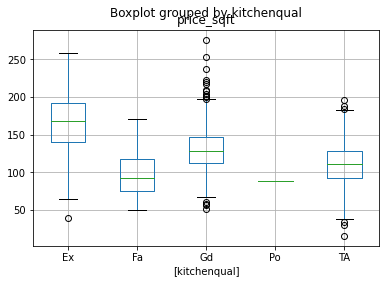

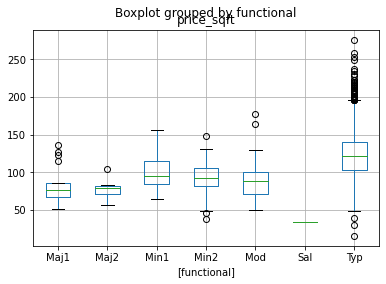

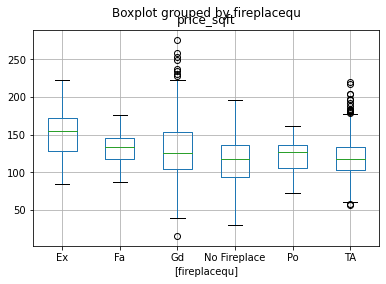

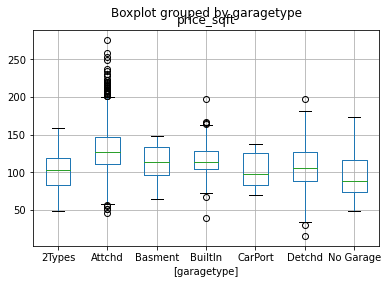

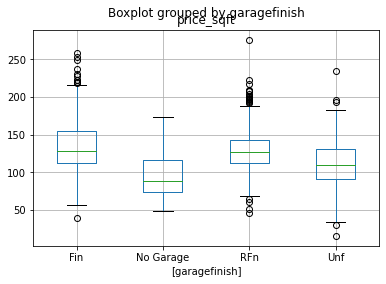

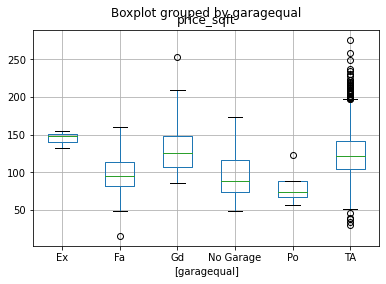

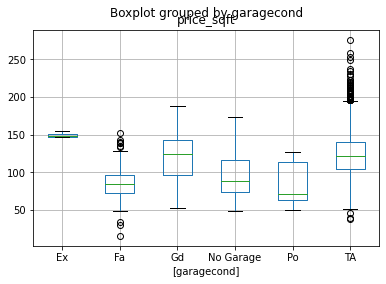

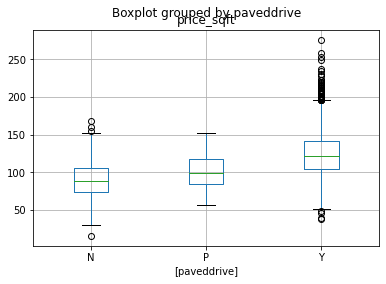

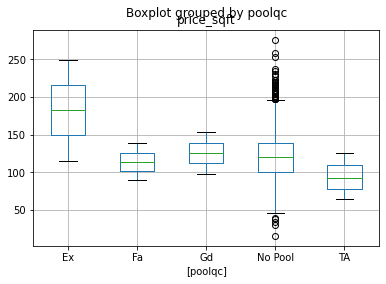

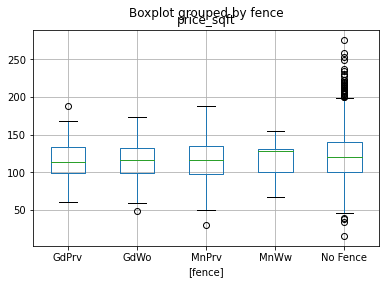

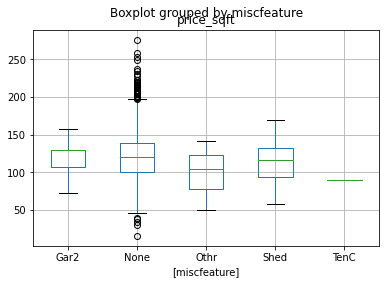

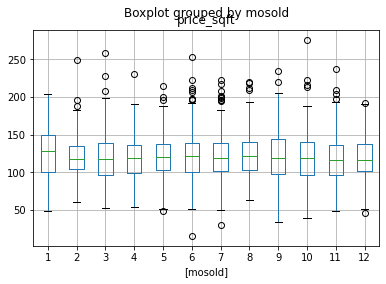

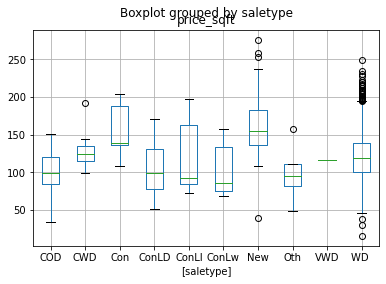

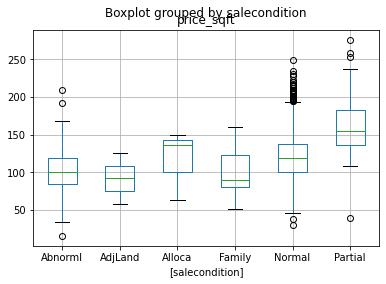

In [21]:
for col in factor_col:
    print(ames2[['price_sqft',col]].boxplot(by = col))

In [22]:
for col in factor_col:
    print(ames2[col].value_counts())

20     939
60     501
50     259
120    169
30     123
160    120
70     115
80     108
90      87
190     53
85      43
75      21
45      17
180     15
40       6
150      1
Name: mssubclass, dtype: int64
RL         2007
RM          416
FV          113
RH           21
C (all)      17
I (all)       2
A (agr)       1
Name: mszoning, dtype: int64
Pave    2567
Grvl      10
Name: street, dtype: int64
No Alley    2410
Grvl         104
Pave          63
Name: alley, dtype: int64
Reg    1638
IR1     855
IR2      71
IR3      13
Name: lotshape, dtype: int64
Lvl    2334
HLS      96
Bnk      95
Low      52
Name: landcontour, dtype: int64
AllPub    2575
NoSewr       2
Name: utilities, dtype: int64
Inside     1883
Corner      439
CulDSac     164
FR2          78
FR3          13
Name: lotconfig, dtype: int64
Gtl    2455
Mod     109
Sev      13
Name: landslope, dtype: int64
NAmes      410
CollgCr    236
OldTown    212
Edwards    165
Somerst    143
Gilbert    143
Sawyer     139
NWAmes     123
NridgHt  

By looking at the boxplots, it seems 'street', 'lotshape', 'loconfig', 'landslope', 'heatingqc', and 'fence' don't have strong influence on the price/sqft. May consider eliminating these features in the next steps.

Another observation is that many of the features have unbalanced values. This should be taken into consideration if any features are to be included in the model.

### Standardize Numeric Variables

Standardize all the numeric variables for better comparebility for the beta coefiicients.

In [27]:
ames3 = ames2.copy()
for col in ames3.columns.tolist():
    if ames3[col].dtype != 'O':
        ames3[col] = (ames3[col] - ames3[col].mean()) / ames3[col].std()

In [28]:
ames_numeric = ames2[ames2.columns[~ames2.columns.isin(factor_col)].tolist()]

### Dummify variables

In [29]:
for col in factor_col:
    col_df = dummy_dict[col].drop(col+'_'+str(ames2[col].mode()[0]),axis=1)
    ames3 = pd.concat([ames3, col_df], join='inner',axis=1)
    ames3.drop(col, axis=1, inplace=True)
    
ames3.head()

,pid,grlivarea,saleprice,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,yrsold,price_sqft,house_age,reno_age,tbath_abvgr,tbath_bsmt,tbath,bbratio_abvgr,mssubclass_30,mssubclass_40,mssubclass_45,mssubclass_50,mssubclass_60,mssubclass_70,mssubclass_75,...,garagefinish_RFn,garagequal_Ex,garagequal_Fa,garagequal_Gd,garagequal_No Garage,garagequal_Po,garagecond_Ex,garagecond_Fa,garagecond_Gd,garagecond_No Garage,garagecond_Po,paveddrive_N,paveddrive_P,poolqc_Ex,poolqc_Fa,poolqc_Gd,poolqc_TA,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,miscfeature_Gar2,miscfeature_Othr,miscfeature_Shed,miscfeature_TenC,mosold_1,mosold_2,mosold_3,mosold_4,mosold_5,mosold_7,mosold_8,mosold_9,mosold_10,mosold_11,mosold_12,saletype_COD,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_VWD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Partial
0,1.031373,-1.288395,-0.693753,-1.680863,-0.274425,-0.034321,0.340791,-1.055627,-1.646136,-0.563072,-0.480599,-0.305356,0.186097,-0.430868,-0.768915,-0.793117,-0.095647,1.088180,-0.253878,-1.007922,-0.757806,-1.033076,-0.199133,-1.554027,0.609004,0.138702,0.341406,-0.327210,-0.742743,-0.698224,-0.360990,-0.099341,2.634426,-0.054813,-0.09706,1.646193,0.857182,1.128072,1.755262,-1.158296,1.039766,-0.258156,0.232790,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.011761,-0.893539,-0.513925,-0.425652,-0.723910,-0.765275,-0.550802,0.460020,0.012818,0.285371,0.250536,1.946982,-1.022333,0.029770,-0.255717,-0.793117,-0.095647,1.088180,-0.253878,0.823824,-0.757806,-1.033076,-0.199133,-0.902852,-0.932650,0.243674,-1.012138,-0.968043,-0.742743,0.890750,-0.360990,-0.099341,-0.285273,-0.054813,-0.09706,0.884570,0.393284,-0.420770,0.043906,0.408185,1.039766,0.995882,-1.065132,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.041719,-0.991742,-0.708406,0.112296,-0.499475,-0.765275,3.015569,-1.358757,1.135052,-0.563072,0.681301,-0.305356,-1.031737,-0.476216,-0.383351,-0.793117,-0.095647,-0.839132,-0.253878,-1.007922,-0.757806,-1.033076,-0.199133,-0.902852,-0.932650,0.117707,-1.012138,-1.208957,0.449979,-0.698224,0.295661,3.298725,-0.285273,-0.054813,-0.09706,-0.638676,0.125354,1.330095,-1.178491,-1.158296,-0.908944,-1.512193,0.232790,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.950020,-0.913998,-0.853601,0.710015,-0.242943,-1.496229,2.123977,-2.369188,0.939881,-0.563072,-1.034772,-0.305356,-0.314672,-1.507281,-1.138524,-0.033797,-0.095647,-0.839132,-0.253878,-1.007922,-0.757806,-1.033076,-0.199133,-0.251677,-0.932650,0.141034,-1.012138,-0.895768,-0.742743,-0.698224,2.265615,-0.099341,1.667056,-0.054813,-0.09706,0.884570,-0.366024,2.407551,-0.885116,-1.158296,-0.908944,-1.512193,0.232790,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.956380,0.366725,0.651627,0.411155,-0.211707,1.427587,0.340791,1.032598,0.842295,-0.563072,0.462426,-0.305356,-0.874218,-0.540657,-0.891232,1.223089,-0.095647,1.088180,-0.253878,0.823824,1.245133,0.183113,-0.199133,-0.251677,-0.932650,0.283330,0.341406,0.294349,-0.742743,-0.017235,-0.360990,-0.099341,-0.285273,-0.054813,-0.09706,0.884570,0.502711,-0.993168,-0.787324,1.191425,1.039766,1.622901,-0.805547,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Create Features Series and Target DataFrame

In [31]:
target = ames3['price_sqft']
full_features = ames3[['grlivarea','lotfrontage','lotarea','overallqual','overallcond','yearbuilt',
                       'yearremodadd','masvnrarea','bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf',
                       '1stflrsf','2ndflrsf','lowqualfinsf','bsmtfullbath','bsmthalfbath','fullbath',
                       'halfbath','bedroomabvgr','kitchenabvgr','totrmsabvgrd','fireplaces','garageyrblt',
                       'garagecars','garagearea','wooddecksf','openporchsf','enclosedporch','3ssnporch',
                       'screenporch','poolarea','miscval','yrsold','house_age',
                       'reno_age','tbath_abvgr','tbath_bsmt','tbath','bbratio_abvgr','mssubclass_30',
                       'mssubclass_40','mssubclass_45','mssubclass_50','mssubclass_60','mssubclass_70',
                       'mssubclass_75','mssubclass_80','mssubclass_85','mssubclass_90','mssubclass_120',
                       'mssubclass_150','mssubclass_160','mssubclass_180','mssubclass_190','mszoning_A (agr)',
                       'mszoning_C (all)','mszoning_FV','mszoning_I (all)','mszoning_RH','mszoning_RM',
                       'street_Grvl','alley_Grvl','alley_Pave','lotshape_IR1','lotshape_IR2','lotshape_IR3',
                       'landcontour_Bnk','landcontour_HLS','landcontour_Low','utilities_NoSewr',
                       'lotconfig_Corner','lotconfig_CulDSac','lotconfig_FR2','lotconfig_FR3','landslope_Mod',
                       'landslope_Sev','neighborhood_Blmngtn','neighborhood_Blueste','neighborhood_BrDale',
                       'neighborhood_BrkSide','neighborhood_ClearCr','neighborhood_CollgCr','neighborhood_Crawfor',
                       'neighborhood_Edwards','neighborhood_Gilbert','neighborhood_Greens','neighborhood_GrnHill',
                       'neighborhood_IDOTRR','neighborhood_Landmrk','neighborhood_MeadowV','neighborhood_Mitchel',
                       'neighborhood_NPkVill','neighborhood_NWAmes','neighborhood_NoRidge','neighborhood_NridgHt',
                       'neighborhood_OldTown','neighborhood_SWISU','neighborhood_Sawyer','neighborhood_SawyerW',
                       'neighborhood_Somerst','neighborhood_StoneBr','neighborhood_Timber','neighborhood_Veenker',
                       'condition1_Artery','condition1_Feedr','condition1_PosA','condition1_PosN','condition1_RRAe',
                       'condition1_RRAn','condition1_RRNe','condition1_RRNn','condition2_Artery','condition2_Feedr',
                       'condition2_PosA','condition2_PosN','condition2_RRAe','condition2_RRAn','condition2_RRNn',
                       'bldgtype_2fmCon','bldgtype_Duplex','bldgtype_Twnhs','bldgtype_TwnhsE','housestyle_1.5Fin',
                       'housestyle_1.5Unf','housestyle_2.5Fin','housestyle_2.5Unf','housestyle_2Story',
                       'housestyle_SFoyer','housestyle_SLvl','roofstyle_Flat','roofstyle_Gambrel','roofstyle_Hip',
                       'roofstyle_Mansard','roofstyle_Shed','roofmatl_Membran','roofmatl_Metal','roofmatl_Roll',
                       'roofmatl_Tar&Grv','roofmatl_WdShake','roofmatl_WdShngl','exterior1st_AsbShng',
                       'exterior1st_AsphShn','exterior1st_BrkComm','exterior1st_BrkFace','exterior1st_CBlock',
                       'exterior1st_CemntBd','exterior1st_HdBoard','exterior1st_ImStucc','exterior1st_MetalSd',
                       'exterior1st_Plywood','exterior1st_PreCast','exterior1st_Stucco','exterior1st_Wd Sdng',
                       'exterior1st_WdShing','exterior2nd_AsbShng','exterior2nd_AsphShn','exterior2nd_Brk Cmn',
                       'exterior2nd_BrkFace','exterior2nd_CBlock','exterior2nd_CmentBd','exterior2nd_HdBoard',
                       'exterior2nd_ImStucc','exterior2nd_MetalSd','exterior2nd_Plywood','exterior2nd_PreCast',
                       'exterior2nd_Stone','exterior2nd_Stucco','exterior2nd_Wd Sdng','exterior2nd_Wd Shng',
                       'masvnrtype_BrkCmn','masvnrtype_BrkFace','masvnrtype_Missing','masvnrtype_Stone',
                       'exterqual_Ex','exterqual_Fa','exterqual_Gd','extercond_Ex','extercond_Fa','extercond_Gd',
                       'extercond_Po','foundation_BrkTil','foundation_PConc','foundation_Slab','foundation_Stone',
                       'foundation_Wood','bsmtqual_Ex','bsmtqual_Fa','bsmtqual_Gd','bsmtqual_No Bsmt','bsmtqual_Po',
                       'bsmtcond_Ex','bsmtcond_Fa','bsmtcond_Gd','bsmtcond_No Bsmt','bsmtcond_Po','bsmtexposure_Av',
                       'bsmtexposure_Gd','bsmtexposure_Mn','bsmtexposure_No Bsmt','bsmtfintype1_ALQ','bsmtfintype1_BLQ',
                       'bsmtfintype1_LwQ','bsmtfintype1_No Bsmt','bsmtfintype1_Rec','bsmtfintype1_Unf',
                       'bsmtfintype2_ALQ','bsmtfintype2_BLQ','bsmtfintype2_GLQ','bsmtfintype2_LwQ',
                       'bsmtfintype2_No Bsmt','bsmtfintype2_Rec','heating_Floor','heating_GasW','heating_Grav',
                       'heating_OthW','heating_Wall','heatingqc_Fa','heatingqc_Gd','heatingqc_Po','heatingqc_TA',
                       'centralair_N','electrical_FuseA','electrical_FuseF','electrical_FuseP','kitchenqual_Ex',
                       'kitchenqual_Fa','kitchenqual_Gd','kitchenqual_Po','functional_Maj1','functional_Maj2',
                       'functional_Min1','functional_Min2','functional_Mod','functional_Sal','fireplacequ_Ex',
                       'fireplacequ_Fa','fireplacequ_Gd','fireplacequ_Po','fireplacequ_TA','garagetype_2Types',
                       'garagetype_Basment','garagetype_BuiltIn','garagetype_CarPort','garagetype_Detchd',
                       'garagetype_No Garage','garagefinish_Fin','garagefinish_No Garage','garagefinish_RFn',
                       'garagequal_Ex','garagequal_Fa','garagequal_Gd','garagequal_No Garage','garagequal_Po',
                       'garagecond_Ex','garagecond_Fa','garagecond_Gd','garagecond_No Garage','garagecond_Po',
                       'paveddrive_N','paveddrive_P','poolqc_Ex','poolqc_Fa','poolqc_Gd','poolqc_TA','fence_GdPrv',
                       'fence_GdWo','fence_MnPrv','fence_MnWw','miscfeature_Gar2','miscfeature_Othr',
                       'miscfeature_Shed','miscfeature_TenC','saletype_COD','saletype_CWD','saletype_Con',
                       'saletype_ConLD','saletype_ConLI','saletype_ConLw','saletype_New','saletype_Oth',
                       'saletype_VWD','salecondition_Abnorml','salecondition_AdjLand','salecondition_Alloca',
                       'salecondition_Family','salecondition_Partial']]

## Initial Feature Selection 


In [32]:
from sklearn.linear_model import Lasso
lasso = Lasso()

In [33]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(full_features, target, test_size=0.33, random_state=0)

from sklearn.linear_model import Lasso
lasso = Lasso()

coefs = []
intercepts = []
R2_train  = []
R2_test  = []
coefs_dict = {}

alphaRange = np.logspace(-4,2,20)
for alpha in alphaRange:
          lasso.set_params(alpha=alpha)  
          lasso.fit(X_train1, y_train1)
          intercepts.append(lasso.intercept_)
          coefs.append(lasso.coef_)
          coefs_dict[alpha] = lasso.coef_
          R2_train.append(lasso.score(X_train1, y_train1)) 
          R2_test.append(lasso.score(X_test1, y_test1))

C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.161433752075524, tolerance: 0.17301247498778455
  model = cd_fast.enet_coordinate_descent(
C:\Users\Chun\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.07732419700139, tolerance: 0.17301247498778455
  model = cd_fast.enet_coordinate_descent(


In [34]:
for i in range(20):
    alpha = alphaRange[i]
    coef_alpha = coefs_dict[alpha]
    print(i, round(alpha,5), len(coef_alpha[coef_alpha!=0]),round(R2_train[i],5),round(R2_test[i],5))

0 0.0001 235 0.88492 0.82388
1 0.00021 217 0.88253 0.82637
2 0.00043 185 0.87711 0.82727
3 0.00089 145 0.86881 0.82392
4 0.00183 114 0.85651 0.81729
5 0.00379 78 0.83708 0.80269
6 0.00785 50 0.81174 0.77902
7 0.01624 33 0.78513 0.75291
8 0.0336 21 0.74949 0.72151
9 0.06952 15 0.70705 0.68607
10 0.14384 8 0.6085 0.59408
11 0.29764 5 0.37861 0.37234
12 0.61585 0 0.0 -0.00045
13 1.27427 0 0.0 -0.00045
14 2.63665 0 0.0 -0.00045
15 5.45559 0 0.0 -0.00045
16 11.28838 0 0.0 -0.00045
17 23.35721 0 0.0 -0.00045
18 48.3293 0 0.0 -0.00045
19 100.0 0 0.0 -0.00045


By observing the R^2 of training and test data sets, we notice that 0.00379 could be an optimal level for lambda, since the 78 features in the model can explain over 80 percent of variance in price per sqst, and the performance in test data set and train data set are relatively stable.

In [35]:
coef_alpha5 = pd.DataFrame({'feature':full_features.columns, 'coef':coefs_dict[alphaRange[5]]})
picked_feature = coef_alpha5.loc[coef_alpha5.coef != 0,'feature'].tolist()
picked_feature

['grlivarea',
 'lotfrontage',
 'lotarea',
 'overallqual',
 'overallcond',
 'yearbuilt',
 'yearremodadd',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'totalbsmtsf',
 '1stflrsf',
 'lowqualfinsf',
 'bsmtfullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'totrmsabvgrd',
 'fireplaces',
 'garageyrblt',
 'garagecars',
 'garagearea',
 'wooddecksf',
 'openporchsf',
 'enclosedporch',
 '3ssnporch',
 'screenporch',
 'poolarea',
 'miscval',
 'house_age',
 'reno_age',
 'tbath_abvgr',
 'tbath_bsmt',
 'bbratio_abvgr',
 'mssubclass_85',
 'mssubclass_120',
 'mssubclass_160',
 'mszoning_RM',
 'lotshape_IR1',
 'lotconfig_CulDSac',
 'neighborhood_BrkSide',
 'neighborhood_Crawfor',
 'neighborhood_Edwards',
 'neighborhood_Gilbert',
 'neighborhood_NWAmes',
 'neighborhood_NoRidge',
 'neighborhood_NridgHt',
 'neighborhood_Sawyer',
 'neighborhood_SawyerW',
 'neighborhood_Somerst',
 'neighborhood_StoneBr',
 'condition1_Artery',
 'condition1_Feedr',
 'bldgtype_Twnhs',
 'housestyle_1.5Fin',
 'housestyle_2

## Data Analysis 

- It seems 'grlivarea','overallqual','yearbuilt', 'masvnrarea', 'totalbsmtsf', 'garagecars','garagearea', 'house_age', 'reno_age', and 'tbath_abvgr' are correlated with many other features.
- 'garagecars' and 'garagearea' are highl correlated
- 'house_age' is correlated with 'yearbuilt', 'bsmtfullbath' is highly correlated with 'tbath_bsmt', as we bring in one of the feature based on another.